In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

useCPU = True
if(useCPU):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from train_utils import plot_confusion_matrix, make_dataframe
import tensorflow as tf
from tensorflow import keras
from keras import metrics
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print("Tensorflow version is ", tf.__version__)

Tensorflow version is  2.0.0-alpha0


Using TensorFlow backend.


## setup training

In [ ]:
width_image = 224
height_image = 224
batch_size = 32
img_shape = (width_image, height_image, 3)

categories = os.listdir('dataset\\v2')
data_frames = make_dataframe('dataset\\v2', validation_percentage = 0.13, test_percentage=0.17)

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15.
)
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [ ]:
# make generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_frames[0],
    x_col='path',
    y_col='label',
    class_mode = 'categorical',
    target_size = (width_image, height_image),
    batch_size = batch_size)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=data_frames[1],
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    target_size=(width_image, height_image),
    batch_size = batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_frames[2],
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    target_size=(width_image, height_image),
    batch_size = batch_size,
    shuffle=False
)

In [ ]:
# get pre-trained MobileNet V2
#base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
#                                                include_top=False,
#                                                weights='imagenet')

#base_model = tf.keras.applications.InceptionResNetV2(input_shape=img_shape,
#                                                include_top=False,
#                                                weights='imagenet')

base_model = tf.keras.applications.densenet.DenseNet121(input_shape=img_shape,
                                                include_top=False,
                                                weights='imagenet')

# feature extraction reuse, T
for layer in base_model.layers:
    layer.trainable = False

## create model over pre-trained net

In [ ]:
# create model over pre-trained graph
model = tf.keras.Sequential([
    base_model,
#    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
#                       activation=tf.nn.relu, input_shape=(len(categories),)),
#    keras.layers.Dropout(0.5),
#    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
#                       activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(len(categories), activation='softmax')
])

In [ ]:
# add the optmizer, loss function and metric for evaluate the training
optimizer = keras.optimizers.Adam()
# optimizer = keras.optimizers.Nadam()
# optimizer = keras.optimizers.Adadelta()
# tensorflow guide use:
#optimizer = tf.keras.optimizers.RMSprop(lr=0.0001)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

## Tranining Phase

In [ ]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
test_steps = test_generator.n // batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs, 
    validation_data = validation_generator,
    validation_steps = validation_steps
)

## Fine tuning

In [ ]:
#Enable chage of all net weight's including the pre-trained
epochs_fine = 200
print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
# set the level to fine-tune
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False
    
for layer in model.layers[fine_tune_at:]:
    layer.trainable = True

In [ ]:
# recompile model with optimizer
optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
#optimizer = tf.keras.optimizers.RMSprop(lr=2e-5)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

In [ ]:
# fit fine-tuning
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs = epochs_fine,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

## Plotting Validation accuracy/loss

In [ ]:
%matplotlib inline

# training and validation accuracy/loss
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

if('history_fine' in globals()):
    acc += history_fine.history['acc']
    val_acc += history_fine.history['val_acc']
    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## Plotting confusion matrix

In [ ]:
# confusion matrix
Y_pred = model.predict_generator(test_generator, test_steps)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

# classification report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=categories))

# evaluate keras model with model.evaluate()
x, y = zip(*(test_generator[i] for i in range(len(test_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: {0:0.1f}%".format(acc * 100))
print("Loss: {0:0.1f}%".format(loss * 100))


plot_confusion_matrix(test_generator.classes, y_pred, categories)

In [ ]:
# save the model
name = '.\\saved_model\\adam_densnet121_fine_tuning.h5'
model.save(name)

##### Try to predict with model

In [2]:
from tensorflow.keras.models import Model
categories = os.listdir('dataset\\v2')
loaded_model = keras.models.load_model('.\\saved_model\\adam_densnet121_fine_tuning.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


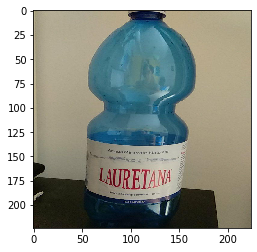

In [3]:
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input

img_path = 'plastic.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255
x = preprocess_input(x)
plt.imshow(img)

In [4]:
preds = loaded_model.predict(x)
print(preds)

[[1.1771771e-03 8.7433803e-01 1.3143416e-04 8.4789880e-02 3.9563537e-02]]
